In [ ]:
# load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep

**Membaca Dataset**

In [ ]:
# import dataset
data = pd.read_csv("AdSmartABdata.csv")
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [ ]:
# dimensi data
data.shape

(8077, 9)

In [ ]:
# overview data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [ ]:
# Periode eksperimen
data['date'].unique()

array(['2020-07-10', '2020-07-07', '2020-07-05', '2020-07-03',
       '2020-07-09', '2020-07-04', '2020-07-06', '2020-07-08'],
      dtype=object)

Deskripsi Variabel

`auction_id`: Unique ID dari users yang terekspos dengan kuesioner. Seorang user dapat melihat kuesioner dan memilih untuk tidak merespon. Dalam hal ini nilai kolom `yes` dan `no`-nya adalah 0.

`experiment`: Kelompok di mana users itu ditempatkan. Control berarti kelompok users yang diperlihatkan dummy ad. Exposed berarti kelompok users yang diperlihatkan interactive ad.

`date`: Tanggal dalam format YYYY-MM-DD

`hour`: Jam dalam format HH

`device_make`: Jenis device yang digunakan oleh user

`platform_os`: ID dari OS yang dimiliki oleh user

`browser`: Nama browser yang digunakan oleh user

`yes`: Bernilai 1 apabila user memilih tombol "Yes" pada kuesioner BIO

`no`: Bernilai 0 apabila user memilih tombol "No" pada kuesioner BIO



**Menghitung Jumlah Sampel Minimum**

Di A/B Testing, kita dapat menggunakan formula berikut ini untuk menghitung jumlah sampel minimum.

$$
n = \cfrac{2 σ^2 (z_{1-α/2}+z_{1-β})^2}{δ^2}
$$


  - $n$: sample size di tiap kelompok 
  - $σ$: standard deviasi dari outcome variable
  - $δ$: peningkatan outcome variable yang diinginkan
  - $z_{1-α/2}$: tingkat statistical significance yang diinginkan
  - $z_{1-β}$ : tingkat power yang diinginkan 


Jika kita tentukan nilai alpha 5% dan power level 80% seperti standar industri, maka formula di atas dapat kita sederhanakan:

$$
n = \cfrac{16σ^2}{δ^2}
$$

In [ ]:
# nilai alpha dan beta sudah ditentukan
# tinggal menentukan nilai std_dev dan delta

std_dev = 0.04 # Diketahui berdasarkan data historis
delta = 0.01 # Peningkatan conversion rate yang diinginkan

n = (16 * (0.04**2)) / 0.01**2

print(f'Jumlah minimum sample yang dibutuhkan per kelompok variant adalah {n:.0f} sample')

Jumlah minimum sample yang dibutuhkan per kelompok variant adalah 256 sample


**Mengecek Observasi yang Tidak Merespon Kuesioner**

Seorang user dapat memilih untuk tidak menjawab 'Yes' atau 'No' ketika diperlihatkan kuesioner melalui advertisement. Karena eksperimen ini ingin melihat conversion rate, kita perlu menghapus observasi non-respon tersebut.

In [ ]:
# cek data non-response

data_no_ans = data[(data['yes'] == 0) & (data['no'] == 0)]
data_no_ans

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
5,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,2020-07-03,15,Samsung SM-G960F,6,Facebook,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [ ]:
# drop non-response data

new_data = data.drop(data_no_ans.index)
new_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


In [ ]:
# dimensi data baru
new_data.shape

(1243, 9)

In [ ]:
# melihat jumlah exposed dan control terbaru
new_data['experiment'].value_counts()

exposed    657
control    586
Name: experiment, dtype: int64

**Mengambil Sampel**

In [ ]:
# mengambil sample control

sample_control = new_data[new_data["experiment"] == "control"]
sample_control = sample_control.sample(n = 256, random_state = 1) 
sample_control

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
7166,e3d9dd45-d1b7-4502-ab4a-d7f9f3a1c272,control,2020-07-08,19,Samsung SM-G960F,6,Chrome Mobile WebView,0,1
3374,6d0b7da0-7798-4b70-88c2-f94e5ab65cb6,control,2020-07-10,4,Generic Smartphone,6,Chrome Mobile,0,1
362,0b0344c4-b114-4705-ad68-6662f0d3bedc,control,2020-07-03,15,LG-$2,6,Chrome Mobile,1,0
6413,cb7d4819-501d-471c-ad2b-f4f945eb411e,control,2020-07-09,19,Samsung SM-G960F,6,Samsung Internet,1,0
3574,735d2323-b1f5-4fb8-9893-96a00e3a4e0f,control,2020-07-05,4,Samsung SM-G975F,6,Chrome Mobile WebView,1,0
...,...,...,...,...,...,...,...,...,...
2116,4584720e-312d-4389-a9d2-ad6c433669b7,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
1624,35e2c4ff-fc94-45ba-992f-58fae55365fc,control,2020-07-04,3,Generic Smartphone,6,Chrome Mobile,0,1
1190,26b140cb-82e2-4318-8837-dc94804e888b,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,1,0
3123,6504ac2f-4b24-48e4-9afd-0fade5317ab5,control,2020-07-04,12,Generic Smartphone,6,Chrome Mobile WebView,0,1


In [ ]:
# mengambil sample treatment
sample_treatment = new_data[new_data["experiment"] == "exposed"]
sample_treatment = sample_treatment.sample(n = 256, random_state = 1)
sample_treatment

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
6025,bf518047-40e7-44e0-a653-16fb004dacab,exposed,2020-07-09,9,Generic Smartphone,6,Chrome Mobile,0,1
7470,ec77e672-dc3d-47ed-9fbb-f9f2a2d71ab7,exposed,2020-07-05,9,Generic Smartphone,6,Chrome Mobile,0,1
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1,0
4071,82a14bc9-b578-4f25-9bef-137c3136a094,exposed,2020-07-03,9,Generic Smartphone,6,Chrome Mobile,0,1
3119,64f4838d-5f0d-49a1-be79-f261ec4d8ddd,exposed,2020-07-04,17,Generic Smartphone,6,Chrome Mobile,0,1
...,...,...,...,...,...,...,...,...,...
3337,6bbc74ed-546f-48b5-bf91-cb8888e96286,exposed,2020-07-05,9,Samsung SM-J530F,6,Samsung Internet,1,0
2598,5378e49b-ec5b-46e8-9e43-03ba4a89a3f7,exposed,2020-07-03,1,Generic Smartphone,6,Chrome Mobile,1,0
4958,9d958055-c1bf-44bb-ab31-f787ca9e116c,exposed,2020-07-08,20,Generic Smartphone,6,Chrome Mobile,1,0
5351,a947b7e4-9a07-436e-8af1-8bad8beea172,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,1


In [ ]:
# menggabungkan dataframe control dan treatment

sample = sample_control.append(sample_treatment, ignore_index = True)
sample

<ipython-input-68-a13e6d46cf6a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample_control.append(sample_treatment, ignore_index = True)


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,e3d9dd45-d1b7-4502-ab4a-d7f9f3a1c272,control,2020-07-08,19,Samsung SM-G960F,6,Chrome Mobile WebView,0,1
1,6d0b7da0-7798-4b70-88c2-f94e5ab65cb6,control,2020-07-10,4,Generic Smartphone,6,Chrome Mobile,0,1
2,0b0344c4-b114-4705-ad68-6662f0d3bedc,control,2020-07-03,15,LG-$2,6,Chrome Mobile,1,0
3,cb7d4819-501d-471c-ad2b-f4f945eb411e,control,2020-07-09,19,Samsung SM-G960F,6,Samsung Internet,1,0
4,735d2323-b1f5-4fb8-9893-96a00e3a4e0f,control,2020-07-05,4,Samsung SM-G975F,6,Chrome Mobile WebView,1,0
...,...,...,...,...,...,...,...,...,...
507,6bbc74ed-546f-48b5-bf91-cb8888e96286,exposed,2020-07-05,9,Samsung SM-J530F,6,Samsung Internet,1,0
508,5378e49b-ec5b-46e8-9e43-03ba4a89a3f7,exposed,2020-07-03,1,Generic Smartphone,6,Chrome Mobile,1,0
509,9d958055-c1bf-44bb-ab31-f787ca9e116c,exposed,2020-07-08,20,Generic Smartphone,6,Chrome Mobile,1,0
510,a947b7e4-9a07-436e-8af1-8bad8beea172,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,1


**Memastikan Kualitas Data**

In [ ]:
# cek missing value
sample.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [ ]:
# cek data duplikat
sample.duplicated('auction_id').sum()

0

In [ ]:
# mengubah kolom 'yes' menjadi 'convert': Bernilai 1 jika user memilih tombol 'yes' dan bernilai 0 apabila user memilih tombol 'no'
sample.drop('no', axis = 1, inplace = True)
sample.rename(columns = {'yes':'converted'}, inplace = True)
sample

,auction_id,experiment,date,hour,device_make,platform_os,browser,converted
0,e3d9dd45-d1b7-4502-ab4a-d7f9f3a1c272,control,2020-07-08,19,Samsung SM-G960F,6,Chrome Mobile WebView,0
1,6d0b7da0-7798-4b70-88c2-f94e5ab65cb6,control,2020-07-10,4,Generic Smartphone,6,Chrome Mobile,0
2,0b0344c4-b114-4705-ad68-6662f0d3bedc,control,2020-07-03,15,LG-$2,6,Chrome Mobile,1
3,cb7d4819-501d-471c-ad2b-f4f945eb411e,control,2020-07-09,19,Samsung SM-G960F,6,Samsung Internet,1
4,735d2323-b1f5-4fb8-9893-96a00e3a4e0f,control,2020-07-05,4,Samsung SM-G975F,6,Chrome Mobile WebView,1
...,...,...,...,...,...,...,...,...
507,6bbc74ed-546f-48b5-bf91-cb8888e96286,exposed,2020-07-05,9,Samsung SM-J530F,6,Samsung Internet,1
508,5378e49b-ec5b-46e8-9e43-03ba4a89a3f7,exposed,2020-07-03,1,Generic Smartphone,6,Chrome Mobile,1
509,9d958055-c1bf-44bb-ab31-f787ca9e116c,exposed,2020-07-08,20,Generic Smartphone,6,Chrome Mobile,1
510,a947b7e4-9a07-436e-8af1-8bad8beea172,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0


**Sample Ratio Mismatch**

Pre analysis

In [ ]:
# membuat data control
data_control = sample[sample['experiment'] == 'control']
data_control.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,converted
0,e3d9dd45-d1b7-4502-ab4a-d7f9f3a1c272,control,2020-07-08,19,Samsung SM-G960F,6,Chrome Mobile WebView,0
1,6d0b7da0-7798-4b70-88c2-f94e5ab65cb6,control,2020-07-10,4,Generic Smartphone,6,Chrome Mobile,0
2,0b0344c4-b114-4705-ad68-6662f0d3bedc,control,2020-07-03,15,LG-$2,6,Chrome Mobile,1
3,cb7d4819-501d-471c-ad2b-f4f945eb411e,control,2020-07-09,19,Samsung SM-G960F,6,Samsung Internet,1
4,735d2323-b1f5-4fb8-9893-96a00e3a4e0f,control,2020-07-05,4,Samsung SM-G975F,6,Chrome Mobile WebView,1


In [ ]:
# membuat data treatment
data_treatment = sample[sample['experiment'] == 'exposed']
data_treatment.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,converted
256,bf518047-40e7-44e0-a653-16fb004dacab,exposed,2020-07-09,9,Generic Smartphone,6,Chrome Mobile,0
257,ec77e672-dc3d-47ed-9fbb-f9f2a2d71ab7,exposed,2020-07-05,9,Generic Smartphone,6,Chrome Mobile,0
258,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1
259,82a14bc9-b578-4f25-9bef-137c3136a094,exposed,2020-07-03,9,Generic Smartphone,6,Chrome Mobile,0
260,64f4838d-5f0d-49a1-be79-f261ec4d8ddd,exposed,2020-07-04,17,Generic Smartphone,6,Chrome Mobile,0


In [ ]:
# menghitung jumlah user di control dan treatment group

n_control = data_control.shape[0]
n_treatment = data_treatment.shape[0]

print(f'Jumlah users di kelompok control    : {n_control} users')
print(f'Jumlah users di kelompok treatment  : {n_treatment} users')

Jumlah users di kelompok control    : 256 users
Jumlah users di kelompok treatment  : 256 users


In [ ]:
# percentase di tiap grup
n_total = sample.shape[0]
persen_control = n_control/n_total * 100
persen_treat = n_treatment/n_total * 100

print(f"% control   : {persen_control:.2f}%")
print(f"% treatment : {persen_treat:.2f}%")

% control   : 50.00%
% treatment : 50.00%


In [ ]:
# membuat variabel observed dan expected value
observed = [ n_control, n_treatment ]
total_traffic= sum(observed)
expected = [ total_traffic/2, total_traffic/2 ]

In [ ]:
# menghitung chi-square statistics
chi = chisquare(observed, f_exp=expected)
print(chi)

Power_divergenceResult(statistic=0.0, pvalue=1.0)


In [ ]:
# perbandingan chi-square statistics dengan critical value
# kita harus menghitung critical value terlebih dahulu

alpha = 0.01
df=(2-1)*(2-1)  

chi_critical = scipy.stats.chi2.ppf(1 - alpha, df)
print(f"Critical value: {chi_critical:.3f}")

Critical value: 6.635


In [ ]:
# Membuat keputusan dari chi-square statistics dan critical value
if chi[0] > chi_critical:
  print("Tolak H0 : Adanya kemungkinan SRM.")
else:
  print("Gagal menolak H0 : Tidak ada SRM")

Gagal menolak H0 : Tidak ada SRM


In [ ]:
# Comparison of P-Value with alpha.
if chi[1] < 0.01:
  print("Tolak H0 : Adanya kemungkinan SRM.")
else:
  print("Gagal menolak H0 : Tidak ada SRM")

Gagal menolak H0 : Tidak ada SRM


Berdasarkan pengecekan kualitas data dan SRM, data yang digunakan pada eksperimen ini sudah bersih dan siap digunakan untuk dianalisis.

**Analisis Data**

Kita ingin mengisi tabel berikut.

<center>

|Group|Banyak User|Count Converted|Conversion Rate|
|:--|:--:|:--:|:--:|
|Control|-|-|-|
|Treatment|-|-|-|

</center>

Di section sebelumnya kita sudah menghitung banyaknya user control dan treatment adalah 256. Selanjutnya kita akan menghitung jumlah user yang converted dan conversion rate-nya.

<center>

|Group|Banyak User|Count Converted|Conversion Rate|
|:--|:--:|:--:|:--:|
|Control|256|-|-|
|Treatment|256|-|-|

</center>

In [ ]:
# banyak user convert di group control

# cari data group control yang convert
data_control_convert = data_control[data_control["converted"] == 1]

# hitung banyak data yang convert
n_control_convert = data_control_convert.shape[0]

n_control_convert

127

In [ ]:
# banyak user convert di group treatment

# cari data group treatment yang convert
data_treatment_convert = data_treatment[data_treatment["converted"] == 1]

# hitung banyak data yang convert
n_treatment_convert = data_treatment_convert.shape[0]

n_treatment_convert

116

In [ ]:
# conversion rate user control
cr_control = n_control_convert / n_control
cr_control

0.49609375

In [ ]:
# conversion rate user treatment
cr_treatment = n_treatment_convert / n_treatment
cr_treatment

0.453125

<center>

|Group|Banyak User|Count Converted|Conversion Rate|
|:--|:--:|:--:|:--:|
|Control|256|127|0.49609375|
|Treatment|256|116|0.453125|

</center>

<ipython-input-90-8c1d1d4326d4>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=["control", "treatment"], fontsize=16)


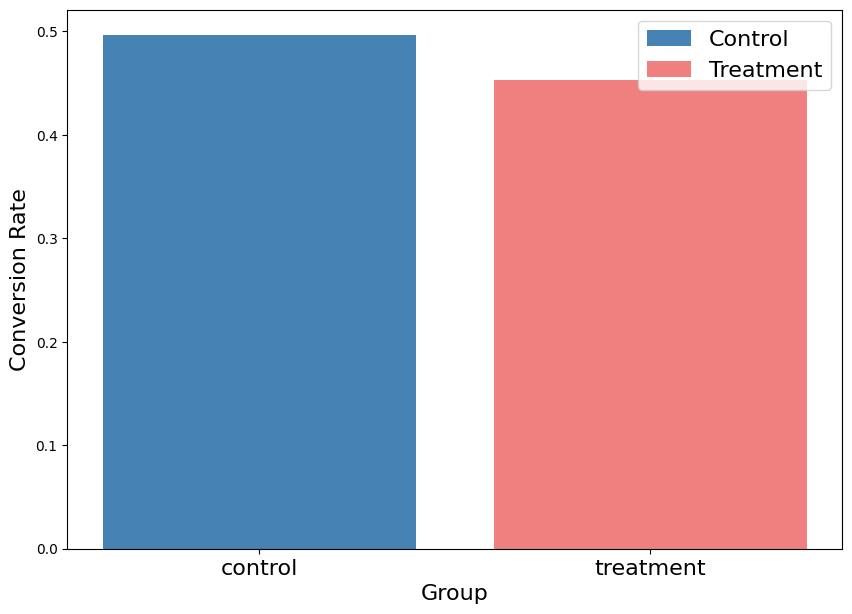

In [ ]:
# dalam visualisasi
# visualisasi perbandingan conversion rate tiap varian
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# buat plot
ax.bar("control", cr_control, color="steelblue", label="Control")
ax.bar("treatment", cr_treatment, color="lightcoral", label="Treatment")

# styling plot
ax.set_ylabel("Conversion Rate", fontsize=16)
ax.set_xlabel("Group", fontsize=16)
ax.set_xticklabels(labels=["control", "treatment"], fontsize=16)
ax.legend(fontsize=16)
plt.show()

Secara visual dan perhitungan, control variant memiliki conversion rate lebih tinggi dibandingkan dengan treatment variant. Untuk memastikan bahwa keputusan yang diambil tidak salah, perlu dilakukan uji statistik untuk membuktikan apakah perbedaan conversion rate 2 kelompok tersebut signifikan secara statistik

**Uji Statistik**

Kita ingin membuktikan conversion rate user yang terekspos dengan interactive ad lebih besar dari conversion rate user yang terekspos dengan dummy ad.

Maka kita bisa mendefinisikan Null hypothesis ($H_0$) dan Alternative hypothesis ($H_1$)

$H_{0}$: $CR_{\text{new}}$ ≤ $CR_{\text{old}}$

$H_{1}$: $CR_{\text{new}}$ > $CR_{\text{old}}$

In [ ]:
# buat count convert & total observation
# variabel total observation sudah kita buat dengan nama 'observed'
count_convert = [n_treatment_convert,n_control_convert]

In [ ]:
# buat alternative
alternative_option = "larger"

In [ ]:
# panggil fungsi
z_stat, p_value = proportions_ztest(count = count_convert,
                                    nobs = observed,
                                    alternative = alternative_option)

print(f"Z stats : {z_stat:.4f}")
print(f"P-value : {p_value:.4f}")

Z stats : -0.9735
P-value : 0.8349


In [ ]:
# hitung selisih cr treatment dengan cr control
cr_treatment - cr_control

-0.04296875

In [ ]:
# tambahan 
# Kita bisa hitung relative effect yang menunjukkan seberapa besar persentase peningkatan atau penurunan conversion rate treatment dibandingkan control
relative_effect = (cr_treatment - cr_control)/cr_control * 100

print(f"relative effect = {relative_effect:.3} %")

relative effect = -8.66 %


Menyimpulkan hasil uji statistik

In [ ]:
# dari p-value
alpha = 0.05        # confidence level yang kita set

# buat decision berdasarkan p_value dan alpha
if p_value < alpha:
    print("Tolak H0")
else:
    print("Gagal menolak H0")

Gagal menolak H0


In [ ]:
# Z critical adalah z-value saat alpha
z_critical = stats.norm.ppf(1 - alpha)

z_critical

1.6448536269514722

In [ ]:
# Dari z-statistics
# Buat decision berdasarkan z_critical dan alpha
if z_stat > z_critical:
    print("Tolak H0")
else:
    print("Gagal menolak H0")

Gagal menolak H0


Berdasarkan hasil uji statistik didapatkan kesimpulan berikut.

- p-value (0.8349) > alpha (0.05) → Gagal menolak H0
- z-statistics (-0.9735) < z tabel (1.644) → Gagal menolak H0


Interactive ad kurang dari atau sama dengan static ad. Dengan kata lain, interactive ad tidak meningkatkan conversion rate

**Menghitung Confidence Interval**

Untuk menghitung confidence interval for proportion, kita dapat menggunakan statsmodels.stats.proportion.confint_proportions_2indep

In [ ]:
# menghitung confidence interval
confidence_interval = confint_proportions_2indep(count1 = n_treatment_convert, nobs1 = n_treatment,
                                                 count2 = n_control_convert, nobs2 = n_control, 
                                                 compare='diff', alpha=0.05)
print(confidence_interval)

(-0.12831107551047496, 0.043269634229198314)


Berdasarkan hasil perhitungan confidence interval, kita yakin 95% bahwa selisih user yang convert pada treatment variant dan control variant terletak antara -0.12  dan 0.04.

Dengan kata lain penerapan interactive ads dapat menurunkan conversion rate sebesar -0.12 atau meningkatkan conversion rate sebesar 0.04

**Kesimpulan**



*   Hasil uji signifikansi menunjukkan hasil yang tidak signifikan baik melihat perbandingan z-statistik dengan z-critical ataupun p-value dengan alpha. Artinya eksperimen ini belum memiliki cukup bukti untuk mengatakan bahwa advertisement yang baru dapat meningkatkan conversion rate
*   Besaran penurunan yang diestimasi menggunakan confidence interval kita yakin 95% bahwa selisih user yang convert pada treatment variant dan control variant terletak antara -0.12  dan 0.04.
*   Selain tidak signifikan, penggunaan advertisement baru (interactive ad) dikhawatirkan dapat meningkatkan loading time (latency) atau error per page yang mana nantinya akan mengganggu conversion rate dalam mengisi kuesioner.
* Eksperimen selanjutnya dapat melakukan A/B Testing lebih mendetail seperti contohnya melakukan A/B Testing berdasarkan browser atau jenis device untuk melihat kemungkinan penerapan interactive ads pada browser atau jenis device tertentu.

